In [2]:
# %pip install sslbookdata
# %pip install scikit-learn
# %pip install matplotlib
# %pip install pandas
# %pip install hdbscan
# %pip install networkx

In [3]:
# Imports

from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt

import networkx as nx

import pandas as pd
import numpy as np
import sslbookdata

O que eu tenho que fazer:
Datasets utilizaveis: USPS, COIL2, DIGIT-1, G-241C, G-241N e TEXT

1) Construi grafos com duas etapas:
HDBSCAN*

2) Construção dos grafos usando um método baseado em densidade criando uma árvore geradora mínima

3) Implementar os métodos de aprendizado (Label difusion) que foram:
* GRF (Gaussian Random Fields)
* LGC (Local and GLobal Consistency)
* LapRLS (Laplacian Regularized Least Squares)
* LapSVM (Laplacian Support Vector Machine)
* RMGT (Robust Multi-class Graph Transductio)

In [4]:
# Upload dos datasets

datasets = {
    'USPS': sslbookdata.load_usps(0),
    'COIL': sslbookdata.load_coil2(0),
    'DIGIT': sslbookdata.load_digit1(0),
    'GC': sslbookdata.load_g241c(0),
    'GN': sslbookdata.load_g241n(0),
    # 'TEXT': sslbookdata.load_text(0)
}

# Primeiro passo do HDBSCAN*

Conceito de Core Distance: Raio mínimo necessário para que uma instância qualquer X seja considerado um objeto core, tendo em vista um número mínimo de pontos próximos (incluindo o próprio ponto)

O primeiro passo do HDBSCAN* é computar a core distance em relação a uma variável de número mínimo de pontos para todos os objetos de X

In [5]:
def computeCoreDistance(datasetToComputeDistance, min_samples):
    list_de_raios_minimos = []
    list_de_indices_vizinhos = []
    neighbors = NearestNeighbors(n_neighbors=min_samples).fit(datasetToComputeDistance)

    distances, indices = neighbors.kneighbors(datasetToComputeDistance)
    for i in range(len(datasetToComputeDistance)):
        list_de_raios_minimos.append(distances[i, -1])
        list_de_indices_vizinhos.append(indices[i])
    return list_de_raios_minimos, list_de_indices_vizinhos

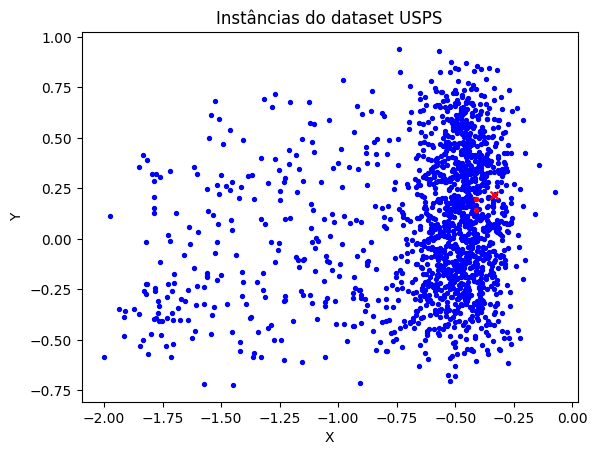

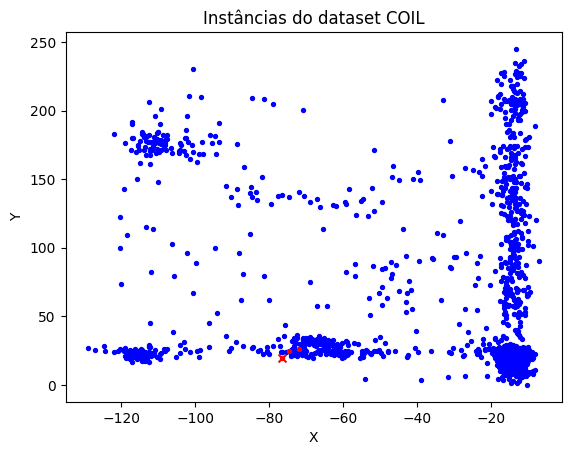

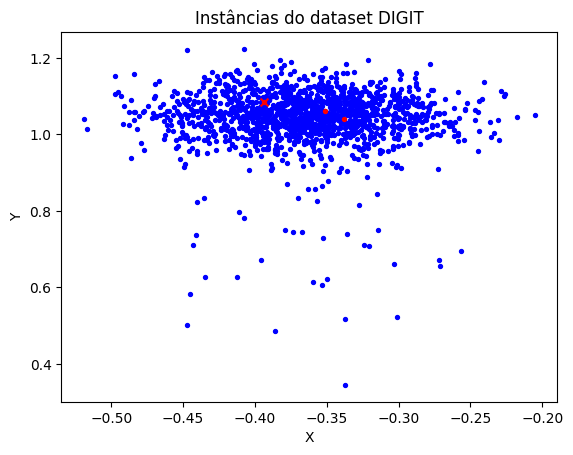

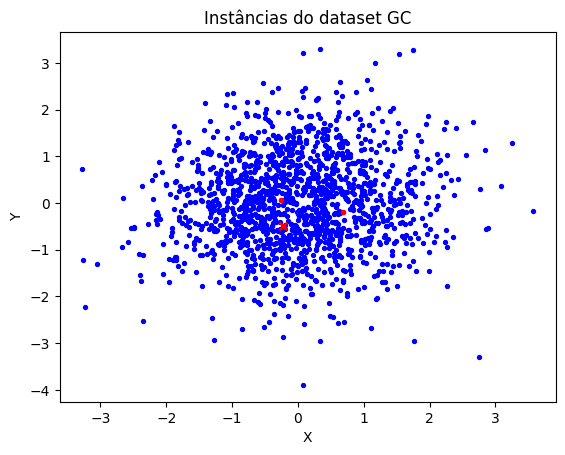

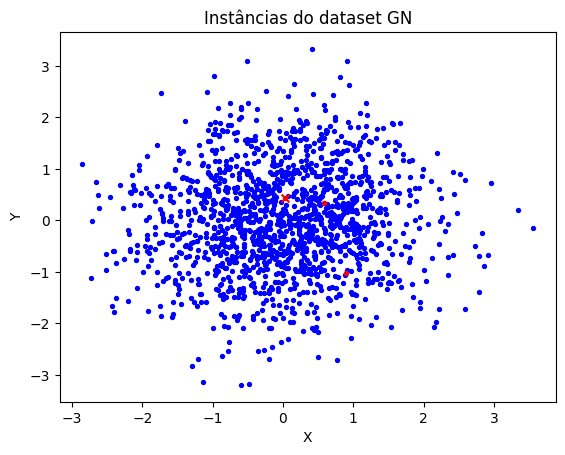

In [6]:
numeroMinimoDePontos = 3

for dataset_name, dataset in datasets.items():
    X = dataset['data']

    plt.figure()
    for i in range(1, len(X)):
        plt.scatter(X[i, 0], X[i, 1], c='b', marker='o', s=8)
    

    listaDeRaiosMinimos, listaDeIndicesVizinhos = computeCoreDistance(X, numeroMinimoDePontos)

    for i in listaDeIndicesVizinhos[0]:
        plt.scatter(X[i, 0], X[i, 1], c='r', marker='o', s=8)
        
    plt.scatter(X[0, 0], X[0, 1], c='r', marker='x', s=32, label='Instância 1')

    print(listaDeRaiosMinimos)
    print(listaDeIndicesVizinhos)
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Instâncias do dataset {dataset_name}')
    plt.show()

    for i, min_radius in enumerate(listaDeRaiosMinimos):
        print(f"Raio mínimo necessário para a instância {i+1} ser um objeto core: {min_radius}")


# Segundo passo do HDBSCAN*

Definição: Gmpts é o grafo de alcançabilidade mútua, sendo um grafo completo, em que os pontos são os objetos do dataset e os pesos das areastas é a distância de alcançabilidade entre os pontos

A distância de alcançabilidade entre os pontos X1 e X2 é dada pelo maior valor entre: CoreDistance(X1), CoreDistance(X2) e Distância(X1, X2)


## Criar uma árvore geradora mínima a partir do Gmpts

In [7]:
# TEMOS QUE CRIAR UMA FUNÇÃO QUE CALCULA A DISTÂNCIA DE ALCANÇABILIDADE ENTRE DOIS PONTOS

def calculoDistanciaAlcancabilidadeMutua():
    distancia_alcancabilidade_mutua = []
    for i in range(len(X)):
        alcancabilidade_mutua = []
        for j in range(len(X)):
            if i != j:
                distancia = np.linalg.norm(X[i] - X[j])
                reachability_distance = max(distancia, listaDeRaiosMinimos[j])
                alcancabilidade_mutua.append(reachability_distance)
        distancia_alcancabilidade_mutua.append(alcancabilidade_mutua)

    print("Distância de Alcançabilidade Mútua:")
    for i in range(len(distancia_alcancabilidade_mutua)):
        for j in range(len(distancia_alcancabilidade_mutua[i])):
            print(f"Ponto {i} para Ponto {j}: {distancia_alcancabilidade_mutua[i][j]}")
    return distancia_alcancabilidade_mutua

In [8]:
G = nx.Graph()

distancia_alcancabilidade_mutua = calculoDistanciaAlcancabilidadeMutua()

num_instancias = len(distancia_alcancabilidade_mutua)
G.add_nodes_from(range(num_instancias))

for i in range(len(distancia_alcancabilidade_mutua)):
    for j in range(len(distancia_alcancabilidade_mutua[i])):
        peso = distancia_alcancabilidade_mutua[i][j]
        G.add_edge(i, j, weight=peso)


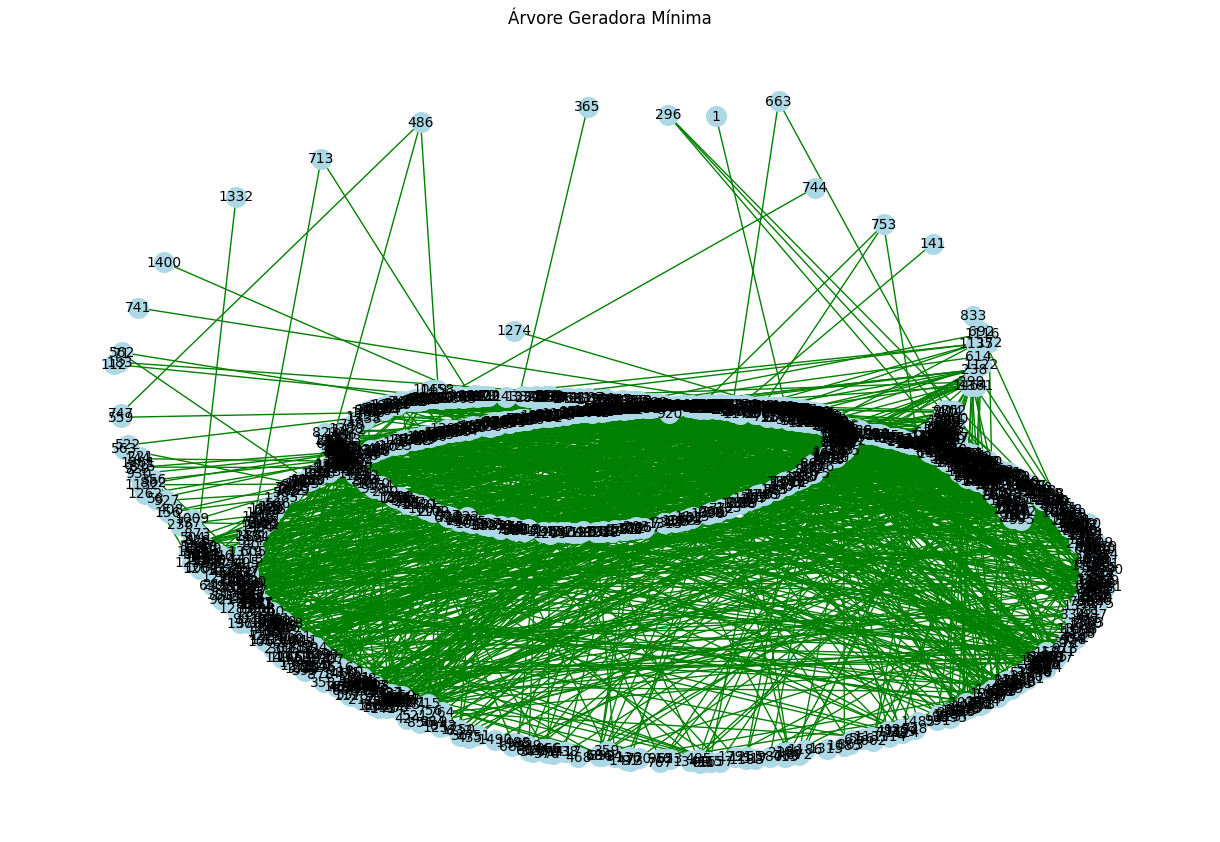

In [9]:
minimum_spanning_tree = nx.minimum_spanning_tree(G)

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))
nx.draw(minimum_spanning_tree, pos, with_labels=True, node_size=200, font_size=10, font_color='black', node_color='lightblue', edge_color='green')
plt.title("Árvore Geradora Mínima")
plt.show()

# Propagação de rótulos a partir da árvore geradora mínima

Precisamos usar todos esses métodos:
* GRF (Gaussian Random Fields)
* LGC (Local and GLobal Consistency)
* LapRLS (Laplacian Regularized Least Squares)
* LapSVM (Laplacian Support Vector Machine)
* RMGT (Robust Multi-class Graph Transductio)